
TOPIC :Email Spam Detection Using Machine Learning Algorithms

# **SPAM EMAIL detection using KNN , SVM, Naive Bayes,Decision Tree and Hybrid (NB+SVM)**

Step 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import hstack
import re
from imblearn.over_sampling import SMOTE
from collections import Counter


Step 2: Load Dataset

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']



Step 3: Exploratory Data Analysis (EDA)


Class Distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


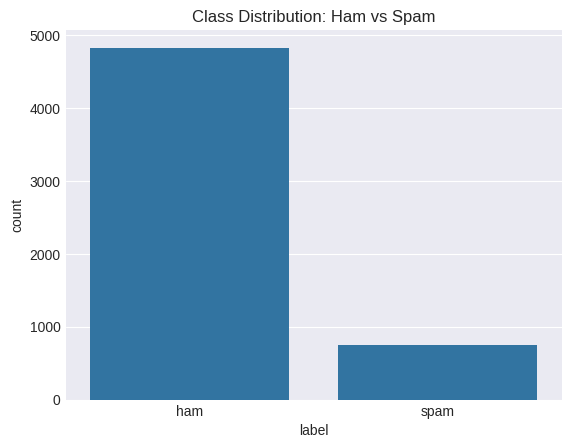

In [ ]:
print("\nClass Distribution:\n", df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Ham vs Spam")
plt.show()


Step 4: Text Length Distribution

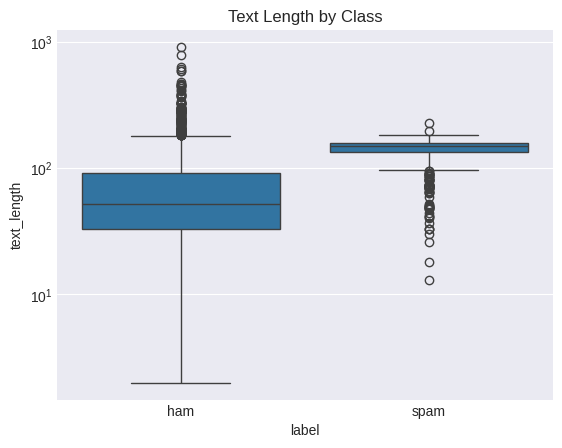

In [ ]:
df['text_length'] = df['message'].apply(len)
sns.boxplot(x='label', y='text_length', data=df)
plt.yscale('log')
plt.title("Text Length by Class")
plt.show()


Step 5: Clean and Preprocess Text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_message'] = df['message'].apply(clean_text)
df['text_length'] = df['cleaned_message'].apply(len)


Step 6: TF-IDF Vectorization + Additional Feature

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_message'])

scaler = MinMaxScaler()
text_length_scaled = scaler.fit_transform(df[['text_length']])

X_combined = hstack([X_tfidf, text_length_scaled])
y = LabelEncoder().fit_transform(df['label'])  # spam=1, ham=0


Step 7: Balance Dataset with SMOTE

In [ ]:
print("Class distribution before SMOTE:", Counter(y))

if df['label'].value_counts().min() / df['label'].value_counts().max() < 0.5:
    smote = SMOTE(random_state=42)
    X_combined, y = smote.fit_resample(X_combined, y)
    print("Class distribution after SMOTE:", Counter(y))


Class distribution before SMOTE: Counter({np.int64(0): 4825, np.int64(1): 747})
Class distribution after SMOTE: Counter({np.int64(0): 4825, np.int64(1): 4825})


Step 8: Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


Step 9: Define and Train Models

In [ ]:
models = {
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}


Step 10: Hybrid Model

In [ ]:
class HybridModel:
    def __init__(self):
        self.nb = MultinomialNB()
        self.svm = SVC(kernel='linear')

    def fit(self, X, y):
        self.nb.fit(X, y)
        svm_train_idx = (self.nb.predict_proba(X)[:, 1] > 0.3)
        self.svm.fit(X[svm_train_idx], y[svm_train_idx])

    def predict(self, X):
        nb_pred = self.nb.predict(X)
        svm_pred = self.svm.predict(X)
        return np.where(nb_pred == 0, nb_pred, svm_pred)

models["Hybrid (NB+SVM)"] = HybridModel()


Step 11: Model Evaluation

In [ ]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })
results_df = pd.DataFrame(results)
print(results_df)


             Model  Accuracy    Recall  Precision  F1-Score
0      Naive Bayes  0.969948  0.985185   0.954872  0.969792
1              KNN  0.777202  0.951323   0.700701  0.807002
2              SVM  0.969948  0.953439   0.984699  0.968817
3    Decision Tree  0.969948  0.969312   0.969312  0.969312
4  Hybrid (NB+SVM)  0.974093  0.985185   0.962771  0.973849


Step 12: Visualization

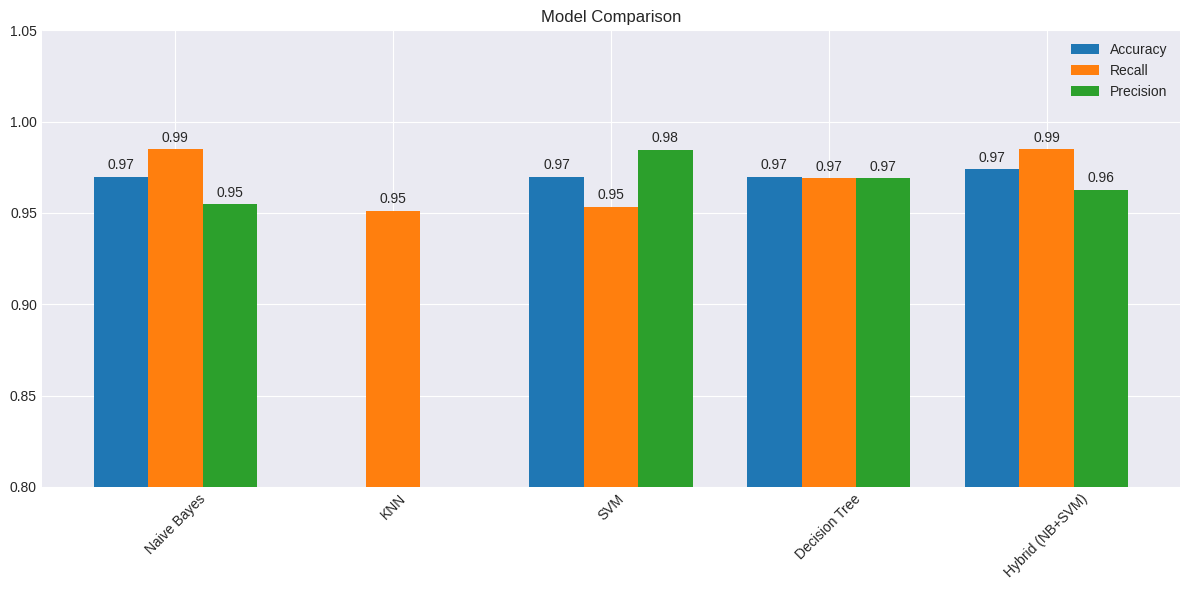

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models))
width = 0.25
for i, metric in enumerate(['Accuracy', 'Recall', 'Precision']):
    rects = ax.bar(x + i * width, results_df[metric], width, label=metric)
    ax.bar_label(rects, fmt='%.2f', padding=3)

ax.set_xticks(x + width)
ax.set_xticklabels(results_df['Model'], rotation=45)
ax.set_title('Model Comparison')
ax.legend()
plt.ylim(0.8, 1.05)
plt.tight_layout()
plt.show()


Step 13: Confusion Matrix for Best Model

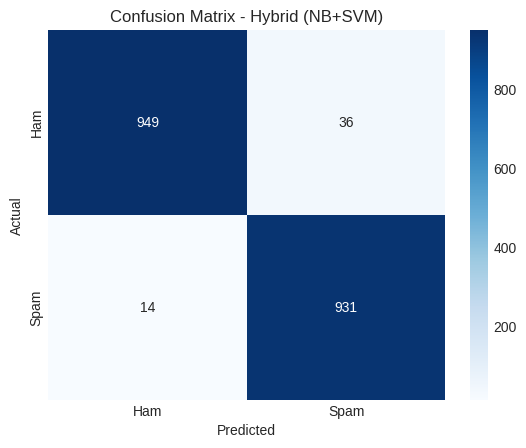

In [ ]:
best_model = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
model = models[best_model]
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Step 14: Word Clouds

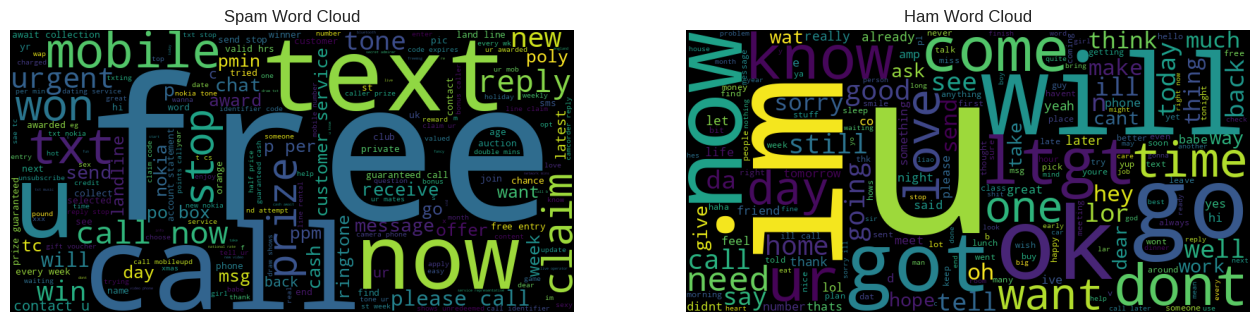

In [ ]:
spam_words = ' '.join(df[df['label'] == 'spam']['cleaned_message'])
ham_words = ' '.join(df[df['label'] == 'ham']['cleaned_message'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(WordCloud(width=800, height=400).generate(spam_words))
ax1.axis('off')
ax1.set_title("Spam Word Cloud")

ax2.imshow(WordCloud(width=800, height=400).generate(ham_words))
ax2.axis('off')
ax2.set_title("Ham Word Cloud")
plt.show()


Checking model

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML


display(HTML("""
<style>
    .widget-label { font-size: 16px !important; color: #f0f0f0; font-weight: bold; }
    .widget-textarea textarea { background-color: #1e1e1e !important; color: #ffffff !important; font-family: monospace; font-size: 15px; border: 1px solid #555; border-radius: 8px; padding: 10px; }
    .widget-button { background-color: #27ae60 !important; color: white !important; border-radius: 8px; font-weight: bold; }
</style>
"""))


input_box = widgets.Textarea(
    value='',
    placeholder='✍️ Type or paste an email/message here...',
    description='📩 Message:',
    layout=widgets.Layout(width='100%', height='100px'),
    style={'description_width': 'initial'}
)

predict_btn = widgets.Button(
    description='🔍 Classify',
    button_style='success',
    tooltip='Click to classify message',
    layout=widgets.Layout(width='150px', height='40px')
)

result_box = widgets.HTML(value="")


def classify_message(b):
    msg = input_box.value.strip()
    if not msg:
        result_box.value = "<span style='color:#e74c3c;font-size:16px'>⚠️ Please enter a message.</span>"
        return

    cleaned = clean_text(msg)
    msg_tfidf = vectorizer.transform([cleaned])
    msg_len = scaler.transform(pd.DataFrame({'text_length': [len(cleaned)]}))
    msg_features = hstack([msg_tfidf, msg_len])

    pred = model.predict(msg_features)[0]
    label = '🚫 <b>SPAM</b>' if pred == 1 else '✅ <b>HAM</b>'
    color = '#e74c3c' if pred == 1 else '#2ecc71'

    result_box.value = f"<span style='color:{color}; font-size:20px'>{label}</span>"

predict_btn.on_click(classify_message)


display(input_box, predict_btn, result_box)


Textarea(value='', description='📩 Message:', layout=Layout(height='100px', width='100%'), placeholder='✍️ Type…

Button(button_style='success', description='🔍 Classify', layout=Layout(height='40px', width='150px'), style=Bu…

HTML(value='')

# **MODEL BASED ON HYBRID MODEL : LOGISTIC REGRESSION AND NAIVE BAYES**

Step 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE

plt.style.use('seaborn-v0_8-darkgrid')


Step 2: Load and Clean Data

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will è b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Step 3: Exploratory Data Analysis (EDA)


Class Distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


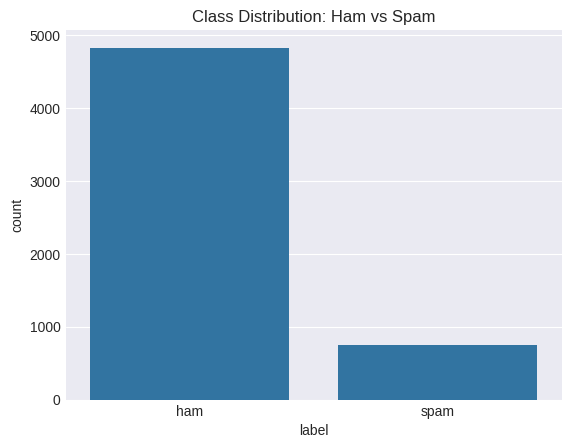

In [ ]:

print("\nClass Distribution:\n", df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Ham vs Spam")
plt.show()

Step 4:Analyze Text Length

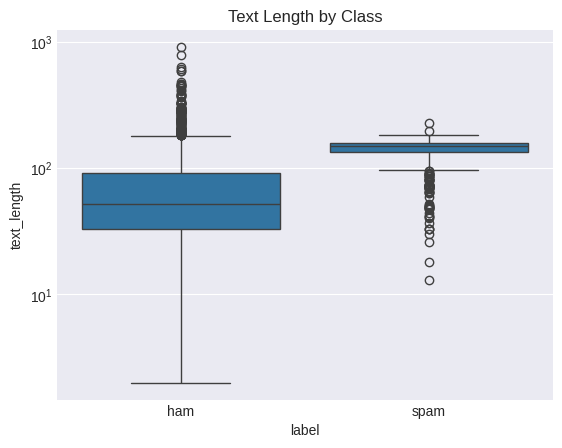

In [ ]:
df['text_length'] = df['message'].apply(len)
sns.boxplot(x='label', y='text_length', data=df)
plt.yscale('log')
plt.title("Text Length by Class")
plt.show()


Step 5: Clean and Preprocess Text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_message'] = df['message'].apply(clean_text)
df['text_length'] = df['cleaned_message'].apply(len)

Step 7: Label Encoding and TF-IDF + Scaled Length Vectorization

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
y = df['label']
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_message'])
scaler = MinMaxScaler()
text_length_scaled = scaler.fit_transform(df[['text_length']])
X_combined = hstack([X_tfidf, text_length_scaled])


Step 8: Apply SMOTE for Handling Imbalance

In [ ]:
if df['label'].value_counts().min() / df['label'].value_counts().max() < 0.5:
    smote = SMOTE(random_state=42)
    X_combined, y = smote.fit_resample(X_combined, y)



Step 9: Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


Step 10: Define Hybrid Model (Naive Bayes + logistic regression)

In [ ]:
class HybridNB_LR:
    def __init__(self):
        self.nb = MultinomialNB()
        self.lr = LogisticRegression(max_iter=1000)

    def fit(self, X, y):
        self.nb.fit(X, y)
        nb_prob = self.nb.predict_proba(X)[:, 1]
        confident_idx = nb_prob > 0.8
        if np.sum(confident_idx) > 0:
            self.lr.fit(X[confident_idx], y[confident_idx])
        else:
            self.lr.fit(X, y)

    def predict(self, X):
        nb_pred = self.nb.predict(X)
        nb_prob = self.nb.predict_proba(X)[:, 1]
        lr_pred = self.lr.predict(X)
        final_pred = np.where(nb_prob > 0.8, nb_pred, lr_pred)
        return final_pred

Step 11: Model Evaluation

In [ ]:
hybrid_model = HybridNB_LR()
hybrid_model.fit(X_train, y_train)
y_pred = hybrid_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))


Accuracy: 0.4896373056994819
Precision: 0.4896373056994819
Recall: 1.0
F1-Score: 0.6573913043478261


Step 12: Display Confusion Matrix

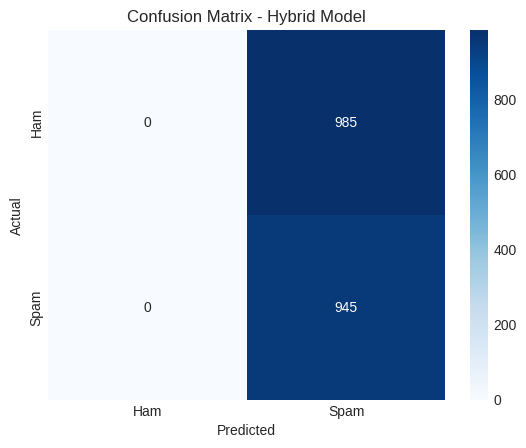

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()


Step 13: Word Cloud Visualization

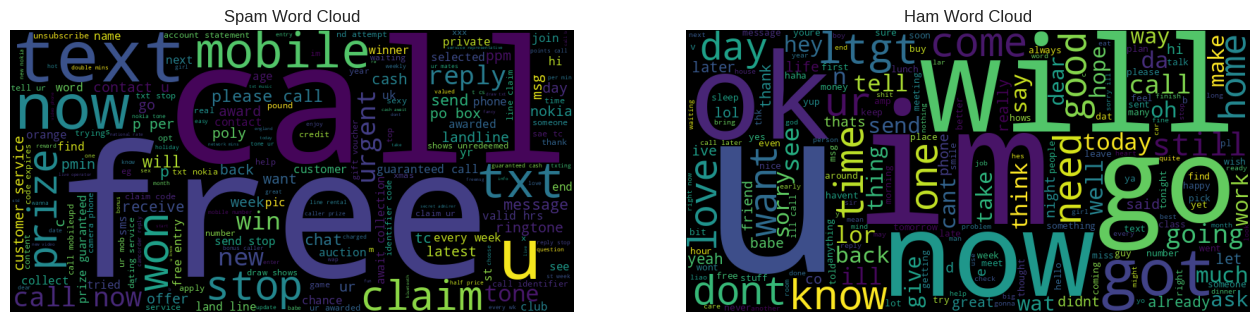

In [ ]:
spam_words = ' '.join(df[df['label'] == 1]['cleaned_message'].dropna())
ham_words = ' '.join(df[df['label'] == 0]['cleaned_message'].dropna())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

if spam_words.strip():
    ax1.imshow(WordCloud(width=800, height=400).generate(spam_words))
    ax1.set_title("Spam Word Cloud")
else:
    ax1.text(0.5, 0.5, 'No spam words found', fontsize=18, ha='center')
ax1.axis('off')

if ham_words.strip():
    ax2.imshow(WordCloud(width=800, height=400).generate(ham_words))
    ax2.set_title("Ham Word Cloud")
else:
    ax2.text(0.5, 0.5, 'No ham words found', fontsize=18, ha='center')
ax2.axis('off')

plt.show()

Step 15: Build GUI for Message Classification

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML


display(HTML("""
<style>
    .widget-label { font-size: 16px !important; color: #f0f0f0; font-weight: bold; }
    .widget-textarea textarea {
        background-color: #1e1e1e !important;
        color: #ffffff !important;
        font-family: monospace;
        font-size: 15px;
        border: 1px solid #555;
        border-radius: 8px;
        padding: 10px;
    }
    .widget-button {
        background-color: #27ae60 !important;
        color: white !important;
        border-radius: 8px;
        font-weight: bold;
        font-size: 15px;
    }
    .confidence-bar {
        background-color: #ddd;
        border-radius: 10px;
        overflow: hidden;
        margin: 10px 0;
    }
    .confidence-fill {
        height: 24px;
        line-height: 24px;
        color: white;
        text-align: center;
        font-weight: bold;
    }
</style>
"""))


input_box = widgets.Textarea(
    value='',
    placeholder='✍️ Type or paste an email/message here...',
    description='📩 Message:',
    layout=widgets.Layout(width='100%', height='120px'),
    style={'description_width': 'initial'}
)


predict_btn = widgets.Button(
    description='🔍 Classify',
    button_style='success',
    tooltip='Click to classify message',
    layout=widgets.Layout(width='150px', height='45px')
)


result_box = widgets.HTML(value="")


def classify_message(b):
    msg = input_box.value.strip()
    if not msg:
        result_box.value = "<span style='color:#e74c3c;font-size:16px'>⚠️ Please enter a message.</span>"
        return

    cleaned = clean_text(msg)
    msg_tfidf = vectorizer.transform([cleaned])
    msg_len = scaler.transform(pd.DataFrame({'text_length': [len(cleaned)]}))
    msg_features = hstack([msg_tfidf, msg_len])


    prob_spam = hybrid_model.nb.predict_proba(msg_features)[0][1]
    prob_ham = hybrid_model.nb.predict_proba(msg_features)[0][0]
    pred = 1 if prob_spam >= 0.5 else 0

    label = '🚫 <b>SPAM</b>' if pred == 1 else '✅ <b>HAM</b>'
    label_color = '#e74c3c' if pred == 1 else '#2ecc71'

    result_box.value = f"""
    <div style='font-size:20px; font-weight:bold; margin-bottom:10px; color:{label_color};'>{label}</div>

    <div>
        <div style='margin:5px 0;'>✅ Ham Confidence: {prob_ham * 100:.2f}%</div>
        <div class='confidence-bar'>
            <div class='confidence-fill' style='width: {prob_ham * 100:.2f}%; background-color: #2ecc71;'>
                {prob_ham * 100:.1f}%
            </div>
        </div>
        <div style='margin:5px 0;'>🚫 Spam Confidence: {prob_spam * 100:.2f}%</div>
        <div class='confidence-bar'>
            <div class='confidence-fill' style='width: {prob_spam * 100:.2f}%; background-color: #e74c3c;'>
                {prob_spam * 100:.1f}%
            </div>
        </div>
    </div>
    """


predict_btn.on_click(classify_message)


display(input_box, predict_btn, result_box)


Textarea(value='', description='📩 Message:', layout=Layout(height='120px', width='100%'), placeholder='✍️ Type…

Button(button_style='success', description='🔍 Classify', layout=Layout(height='45px', width='150px'), style=Bu…

HTML(value='')